In [ ]:
#IMPLEMENTED WITH PYTHON ENVIRONMENT 
#------FACEDETECT

In [2]:

import torch,torchvision

import detectron2

from detectron2.utils.logger import setup_logger

setup_logger()

import glob

import os

import ntpath

import numpy as np

import cv2

import random

import itertools

import pandas as pd

from tqdm import tqdm

import urllib

import json

import PIL.Image as Image

from detectron2 import model_zoo

from detectron2.engine import DefaultPredictor, DefaultTrainer

from detectron2.config import get_cfg

from detectron2.utils.visualizer import Visualizer, ColorMode

from detectron2.data import DatasetCatalog, MetadataCatalog, build_detection_test_loader

from detectron2.evaluation import COCOEvaluator, inference_on_dataset

from detectron2.structures import BoxMode

import seaborn as sns

from pylab import rcParams

import matplotlib.pyplot as plt

from matplotlib import rc

%matplotlib inline

%config InlineBackend.figure_format='retina'

sns.set(style='whitegrid', palette='muted', font_scale=1.2)

HAPPY_COLORS_PALETTE = ["#01BEFE", "#FFDD00", "#FF7D00", "#FF006D", "#ADFF02", "#8F00FF"]

sns.set_palette(sns.color_palette(HAPPY_COLORS_PALETTE))

rcParams['figure.figsize'] = 12, 8

RANDOM_SEED = 42

np.random.seed(RANDOM_SEED)

torch.manual_seed(RANDOM_SEED)

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 

** fvcore version of PathManager will be deprecated soon. **
** Please migrate to the version in iopath repo. **
https://github.com/facebookresearch/iopath 



In [3]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [4]:
import pandas as pd
df=pd.read_csv("./data/annotations_boxes_training.csv",sep=" ",names=["filename","id","class_name","presence","x_min","y_min","x_max","y_max"])

print(df.head())
print(len(df))
df["filename"]=df["filename"]+".JPG"
df.insert(2,"width",4032)
df.insert(3,"height",3024)


df.to_csv("./data/detectron2.csv",index=None)
df.head()


               filename  id              class_name  presence  x_min  y_min  \
0  2018_0712_073641_101   0         c_sponge_barrel         1    594   1609   
1  2018_0712_073641_101   1            c_soft_coral         1    488    276   
2  2018_0712_073641_101   2  c_hard_coral_branching         1   1227   1366   
3  2018_0712_073641_101   3            c_soft_coral         1   1271   1997   
4  2018_0712_073641_101   4  c_hard_coral_branching         1   2268    520   

   x_max  y_max  
0   1023   2043  
1    941    539  
2   1394   1515  
3   1486   2206  
4   2507    752  
21749


,filename,id,width,height,class_name,presence,x_min,y_min,x_max,y_max
0,2018_0712_073641_101.JPG,0,4032,3024,c_sponge_barrel,1,594,1609,1023,2043
1,2018_0712_073641_101.JPG,1,4032,3024,c_soft_coral,1,488,276,941,539
2,2018_0712_073641_101.JPG,2,4032,3024,c_hard_coral_branching,1,1227,1366,1394,1515
3,2018_0712_073641_101.JPG,3,4032,3024,c_soft_coral,1,1271,1997,1486,2206
4,2018_0712_073641_101.JPG,4,4032,3024,c_hard_coral_branching,1,2268,520,2507,752


In [5]:
print(len(df))


df = pd.read_csv('./data/detectron2.csv')
IMAGES_PATH = f'/home/nisnab/workspace/Coral_challenge/data/coral_image/allcoral'
unique_files = df.filename.unique()
train_files = set(np.random.choice(unique_files, int(len(unique_files) * 0.95), replace=False))
train_df = df[df.filename.isin(train_files)]
test_df = df[~df.filename.isin(train_files)]

#len(unique_files)
#this is equal to tatol number of images
#len(test_df)
#len(train_df)
print(train_df.shape,test_df.shape)

classes=df["class_name"].unique().tolist()
print(len(classes))
print(classes)

def create_dataset_dicts(df, classes):
  dataset_dicts = []
  for image_id, img_name in enumerate(df.filename.unique()):

    record = {}

    image_df = df[df.filename == img_name]

    file_path = f'{IMAGES_PATH}/{img_name}'
    record["file_name"] = file_path
    record["image_id"] = image_id
    record["height"] = int(image_df.iloc[0].height)
    record["width"] = int(image_df.iloc[0].width)

    objs = []
    for _, row in image_df.iterrows():

      xmin = int(row.x_min)
      ymin = int(row.y_min)
      xmax = int(row.x_max)
      ymax = int(row.y_max)

      poly = [
          (xmin, ymin), (xmax, ymin), 
          (xmax, ymax), (xmin, ymax)
      ]
      poly = list(itertools.chain.from_iterable(poly))

      obj = {
        "bbox": [xmin, ymin, xmax, ymax],
        "bbox_mode": BoxMode.XYXY_ABS,
        "segmentation": [poly],
        "category_id": classes.index(row.class_name),
        "iscrowd": 0
      }
      objs.append(obj)

    record["annotations"] = objs
    dataset_dicts.append(record)
  return dataset_dicts

for d in ["train", "val"]:
  DatasetCatalog.register(d, lambda d=d: create_dataset_dicts(train_df if d == "train" else test_df, classes))
  MetadataCatalog.get(d).set(thing_classes=classes)
statement_metadata = MetadataCatalog.get("train")

21749
(20654, 10) (1095, 10)
13
['c_sponge_barrel', 'c_soft_coral', 'c_hard_coral_branching', 'c_hard_coral_table', 'c_hard_coral_encrusting', 'c_soft_coral_gorgonian', 'c_sponge', 'c_hard_coral_mushroom', 'c_hard_coral_boulder', 'c_hard_coral_submassive', 'c_hard_coral_foliose', 'c_fire_coral_millepora', 'c_algae_macro_or_leaves']


In [6]:
class CocoTrainer(DefaultTrainer):
  @classmethod
  def build_evaluator(cls, cfg, dataset_name, output_folder=None):
    if output_folder is None:
        os.makedirs("coco_eval", exist_ok=True)
        output_folder = "coco_eval"
    return COCOEvaluator(dataset_name, cfg, False, output_folder)

In [7]:
cfg = get_cfg()
cfg.merge_from_file("/home/nisnab/object_det_coral/lib/python3.8/site-packages/detectron2/model_zoo/configs/COCO-InstanceSegmentation/mask_rcnn_X_101_32x8d_FPN_3x.yaml")
cfg.MODEL.WEIGHTS = "/home/nisnab/object_det_coral/lib/python3.8/site-packages/detectron2/model_zoo/model_final_2d9806.pkl"


In [8]:
cfg.DATASETS.TRAIN = ("train",)
cfg.DATASETS.TEST = ("val",)
cfg.DATALOADER.NUM_WORKERS = 2

In [9]:
cfg.SOLVER.IMS_PER_BATCH = 4
cfg.SOLVER.BASE_LR = 0.001
cfg.SOLVER.WARMUP_ITERS = 1000
cfg.SOLVER.MAX_ITER = 1200
cfg.SOLVER.STEPS = (1000, 1500)
cfg.SOLVER.GAMMA = 0.05

In [10]:
cfg.MODEL.ROI_HEADS.BATCH_SIZE_PER_IMAGE = 64
cfg.MODEL.ROI_HEADS.NUM_CLASSES = len(classes)
cfg.TEST.EVAL_PERIOD = 500

In [15]:
os.makedirs(cfg.OUTPUT_DIR, exist_ok=True)
trainer = CocoTrainer(cfg)
trainer.resume_or_load(resume=False)
#trainer.train()

[03/25 00:03:52 d2.engine.defaults]: Model:
GeneralizedRCNN(
  (backbone): FPN(
    (fpn_lateral2): Conv2d(256, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral3): Conv2d(512, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output3): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral4): Conv2d(1024, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output4): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (fpn_lateral5): Conv2d(2048, 256, kernel_size=(1, 1), stride=(1, 1))
    (fpn_output5): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (top_block): LastLevelMaxPool()
    (bottom_up): ResNet(
      (stem): BasicStem(
        (conv1): Conv2d(
          3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False
          (norm): FrozenBatchNorm2d(num_features=64, eps=1e-05)
        )
      )
      (res

In [16]:
cfg.MODEL.WEIGHTS = os.path.join(cfg.OUTPUT_DIR, "model_final.pth")

cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.65

predictor = DefaultPredictor(cfg)

In [17]:
evaluator = COCOEvaluator("val", cfg, False, output_dir="./output/")
val_loader = build_detection_test_loader(cfg, "val")
inference_on_dataset(trainer.model, val_loader, evaluator)

WARNING [03/25 00:04:07 d2.evaluation.coco_evaluation]: COCO Evaluator instantiated using config, this is deprecated behavior. Please pass tasks in directly
[03/25 00:04:07 d2.data.dataset_mapper]: [DatasetMapper] Augmentations used in inference: [ResizeShortestEdge(short_edge_length=(800, 800), max_size=1333, sample_style='choice')]
[03/25 00:04:07 d2.data.common]: Serializing 44 elements to byte tensors and concatenating them all ...
[03/25 00:04:07 d2.data.common]: Serialized dataset takes 0.08 MiB
[03/25 00:04:07 d2.evaluation.evaluator]: Start inference on 44 images


/home/nisnab/facedetect/lib/python3.8/site-packages/detectron2/modeling/roi_heads/fast_rcnn.py:124: UserWarning: This overload of nonzero is deprecated:
	nonzero()
Consider using one of the following signatures instead:
	nonzero(*, bool as_tuple) (Triggered internally at  /pytorch/torch/csrc/utils/python_arg_parser.cpp:882.)
  filter_inds = filter_mask.nonzero()


[03/25 00:04:13 d2.evaluation.evaluator]: Inference done 11/44. 0.1009 s / img. ETA=0:00:15
[03/25 00:04:18 d2.evaluation.evaluator]: Inference done 21/44. 0.1089 s / img. ETA=0:00:11
[03/25 00:04:23 d2.evaluation.evaluator]: Inference done 39/44. 0.1052 s / img. ETA=0:00:01
[03/25 00:04:24 d2.evaluation.evaluator]: Total inference time: 0:00:14.228813 (0.364841 s / img per device, on 1 devices)
[03/25 00:04:24 d2.evaluation.evaluator]: Total inference pure compute time: 0:00:04 (0.104188 s / img per device, on 1 devices)
[03/25 00:04:24 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[03/25 00:04:24 d2.evaluation.coco_evaluation]: Saving results to ./output/coco_instances_results.json
[03/25 00:04:24 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
COCOeval_opt.evaluate() finished in 0.0

OrderedDict([('bbox',
              {'AP': 3.930973757416904,
               'AP50': 6.441382843143499,
               'AP75': 4.343656648602174,
               'APs': nan,
               'APm': 0.5693069306930693,
               'APl': 4.121228779610576,
               'AP-c_sponge_barrel': 0.0,
               'AP-c_soft_coral': 17.254274265599467,
               'AP-c_hard_coral_branching': 11.999961619883095,
               'AP-c_hard_coral_table': 0.0,
               'AP-c_hard_coral_encrusting': 0.0,
               'AP-c_soft_coral_gorgonian': 0.0,
               'AP-c_sponge': 5.4591727077217005,
               'AP-c_hard_coral_mushroom': 0.0,
               'AP-c_hard_coral_boulder': 12.458276495798591,
               'AP-c_hard_coral_submassive': 0.0,
               'AP-c_hard_coral_foliose': 0.0,
               'AP-c_fire_coral_millepora': nan,
               'AP-c_algae_macro_or_leaves': 0.0}),
             ('segm',
              {'AP': 3.868490953430933,
               'AP50

In [25]:
os.makedirs("annotated_results", exist_ok=True)

test_image_paths = test_df.filename.unique()

In [26]:
for clothing_image in test_image_paths:
  file_path = f'{IMAGES_PATH}/{clothing_image}'
  im = cv2.imread(file_path)
  outputs = predictor(im)
  v = Visualizer(
    im[:, :, ::-1],
    metadata=statement_metadata, 
    scale=1., 
    instance_mode=ColorMode.IMAGE
  )
  instances = outputs["instances"].to("cpu")
  instances.remove('pred_masks')
  v = v.draw_instance_predictions(instances)
  result = v.get_image()[:, :, ::-1]
  filename = ntpath.basename(clothing_image)
  write_res = cv2.imwrite(f'annotated_results/{filename}', result)



In [27]:
annotated_images = [f'annotated_results/{f}' for f in test_df.filename.unique()]

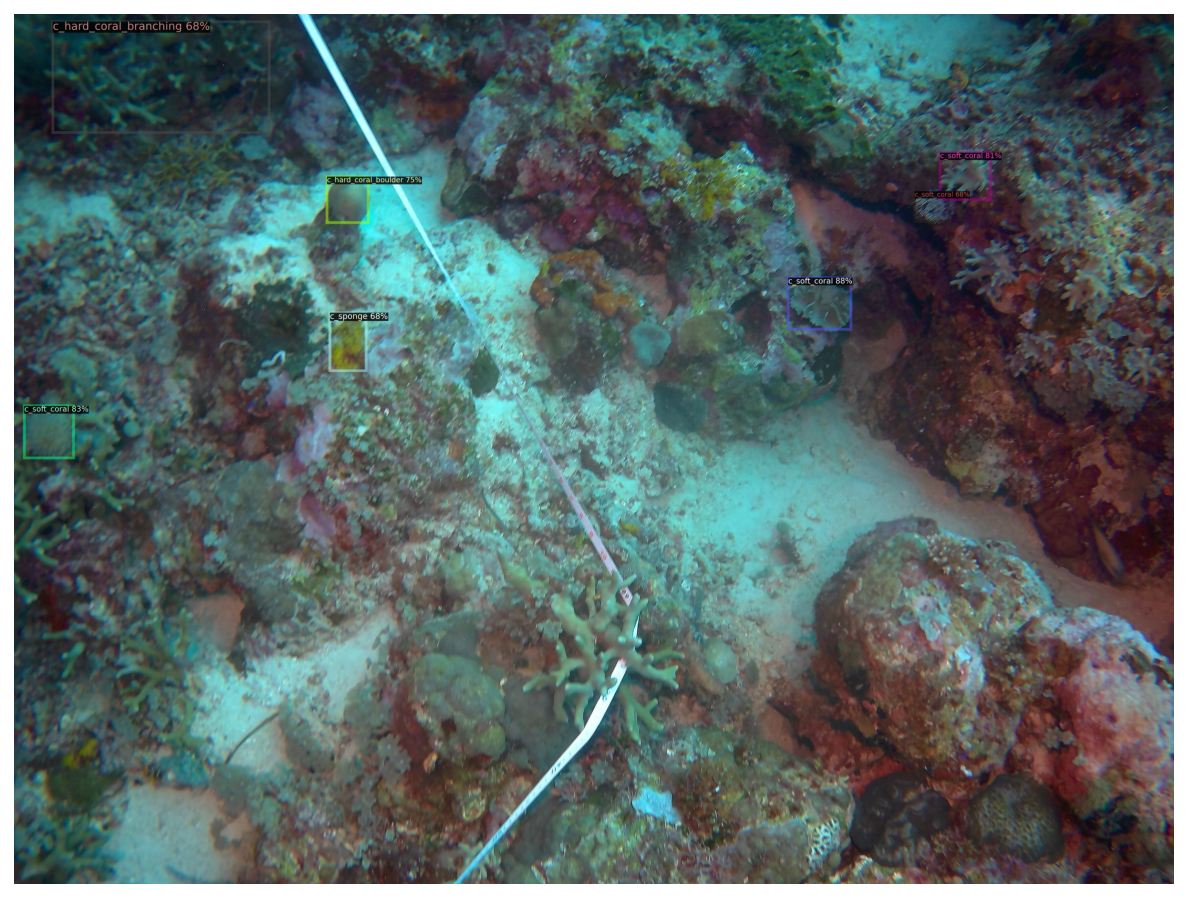

In [28]:
img = cv2.cvtColor(cv2.imread(annotated_images[0]), cv2.COLOR_BGR2RGB)

plt.imshow(img)
plt.axis('off');

In [ ]:
# We can use `Visualizer` to draw the predictions on the image.
v = Visualizer(im[:, :, ::-1], MetadataCatalog.get(cfg.DATASETS.TRAIN[0]), scale=1.2)
out = v.draw_instance_predictions(outputs["instances"].to("cpu"))
cv2_imshow(out.get_image()[:, :, ::-1])